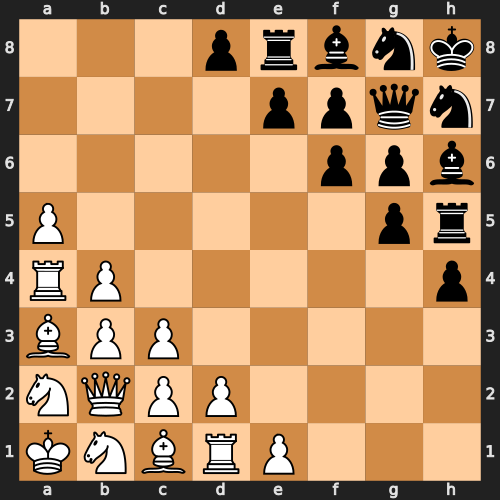

In [2]:
import chess_engine
from chess_engine.diagchess import get_legal_moves_mask 
import random
import matplotlib.pyplot as plt
import numpy as np

env = chess_engine.DiagonalChess()
env.reset()
env.render()

In [3]:
# import modelu
import tensorflow as tf

MODEL_NAMES = {
    "v6": "../retain/chess_v6.0_20230528-170550_13000.h5",
    "v4-1": "../retain/chess_v4.0_20230528-114544_31500.h5",
    "v4-2": "../retain/chess_v4.0_20230527-105139_38000.h5",
    "v4-3": "../retain/chess_v4.0_20230525-231506_107750.h5",
    "v4-4": "../retain/chess_v4.0_20230524-144258_19750.h5",
}

class ChessAgent:
    def __init__(self, model_name):
        self.model = tf.keras.models.load_model(MODEL_NAMES[model_name])
    
    def action_probs(self, state, legal_actions):
        Q_values, critic = self.get_raw(state)
        Q_values = Q_values*legal_actions
        Q_values = Q_values/np.sum(Q_values)

        return Q_values, critic
    
    def get_raw(self, state):
        Q_values, critic = self.model.predict(state[np.newaxis], verbose=0) #type: ignore
        return Q_values[0], critic[0][0]

    def action(self, state, legal_actions):
        actions_prob, _ = self.action_probs(state, legal_actions)

        return np.argmax(actions_prob)
    
def legal_moves(board: chess_engine.DiagonalChess):
    return chess_engine.internal.get_legal_moves_mask(board.board, board.isBlack)

In [3]:
# ten agent zawsze gra białymi
ai_agent = ChessAgent("v4-3")

1. (1, 4, 3, 4)
2. (1, 4, 1, 2)
3. (3, 6, 5, 6)
4. (3, 6, 4, 6)


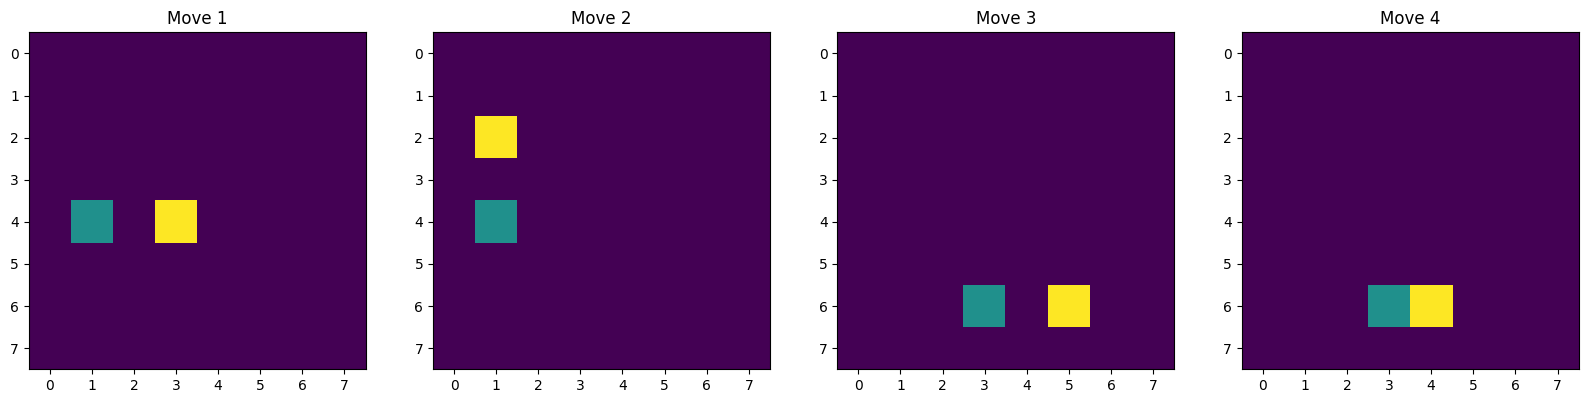

In [4]:
state = env.reset()
probs, critic = ai_agent.action_probs(state, legal_moves(env))

# find best moves
best_moves = np.argsort(probs)[::-1]
best_moves = best_moves[:10]

from chess_engine.diagchess import int_action_to_move

for i, move in enumerate(best_moves[:4]):
    print(f"{i+1}. {int_action_to_move(move)}")

best_moves_imgs = np.zeros((8, 8, 4), dtype=np.uint8)

for i, move in enumerate(best_moves[:4]):
    fromX, fromY, toX, toY = int_action_to_move(move)
    
    best_moves_imgs[fromY, fromX, i] = 128
    best_moves_imgs[toY, toX, i] = 255


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(best_moves_imgs[:,:,i])
    ax[i].set_title(f"Move {i+1}")

In [5]:
# moves probabilities with ids
for i, move in enumerate(best_moves):
    print(f"{i+1}. {int_action_to_move(move)}: {probs[move]:.2f}")

1. (1, 4, 3, 4): 0.56
2. (1, 4, 1, 2): 0.42
3. (3, 6, 5, 6): 0.01
4. (3, 6, 4, 6): 0.01
5. (3, 6, 3, 5): 0.00
6. (4, 7, 4, 6): 0.00
7. (2, 5, 2, 7): -0.00
8. (2, 5, 3, 0): -0.00
9. (2, 5, 3, 1): -0.00
10. (2, 5, 3, 2): 0.00


Text(0.5, 0, 'Probability')

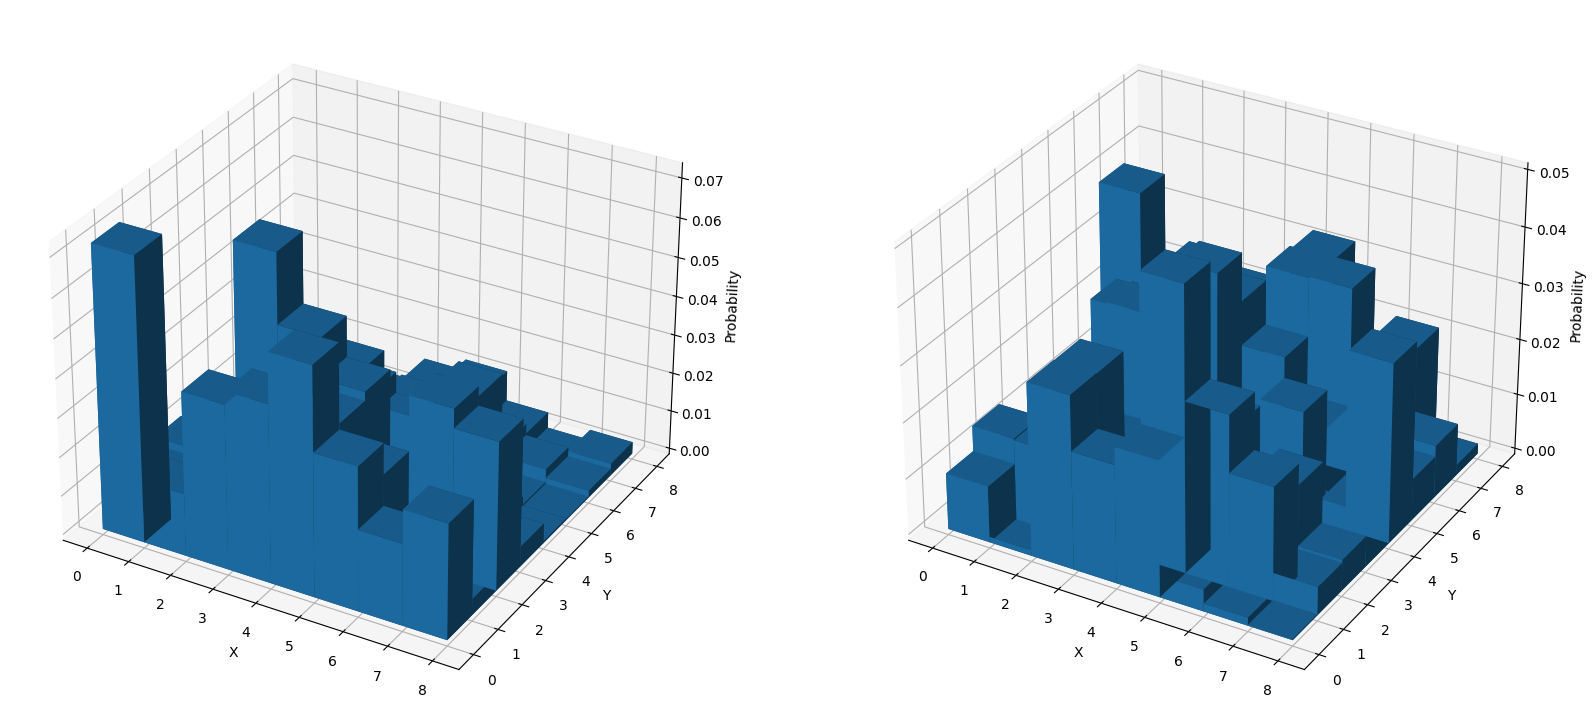

In [6]:
# get raw action
action, critic = ai_agent.get_raw(state)

# normalize
action = action/np.sum(action)

# transform actions to moves
moves = [int_action_to_move(a) for a in action.argsort()[::-1]]

from_moves_cords = [(m[0], m[1], prob) for m, prob in zip(moves, action)] 
to_moves_cords = [(m[2], m[3], prob) for m, prob in zip(moves, action)]

# accumulate probabilities
from_moves_probs = np.zeros((8, 8))
to_moves_probs = np.zeros((8, 8))

for from_x, from_y, prob in from_moves_cords:
    from_moves_probs[from_x, from_y] += prob 

for to_x, to_y, prob in to_moves_cords:
    to_moves_probs[to_x, to_y] += prob

# plot two 3d bar plots with probabilities of moving from and to
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# plot from
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X).ravel(), 1, 1, from_moves_probs.ravel())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability')

# plot to
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

ax2.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X).ravel(), 1, 1, to_moves_probs.ravel())
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Probability')


Text(0.5, 0, 'Probability')

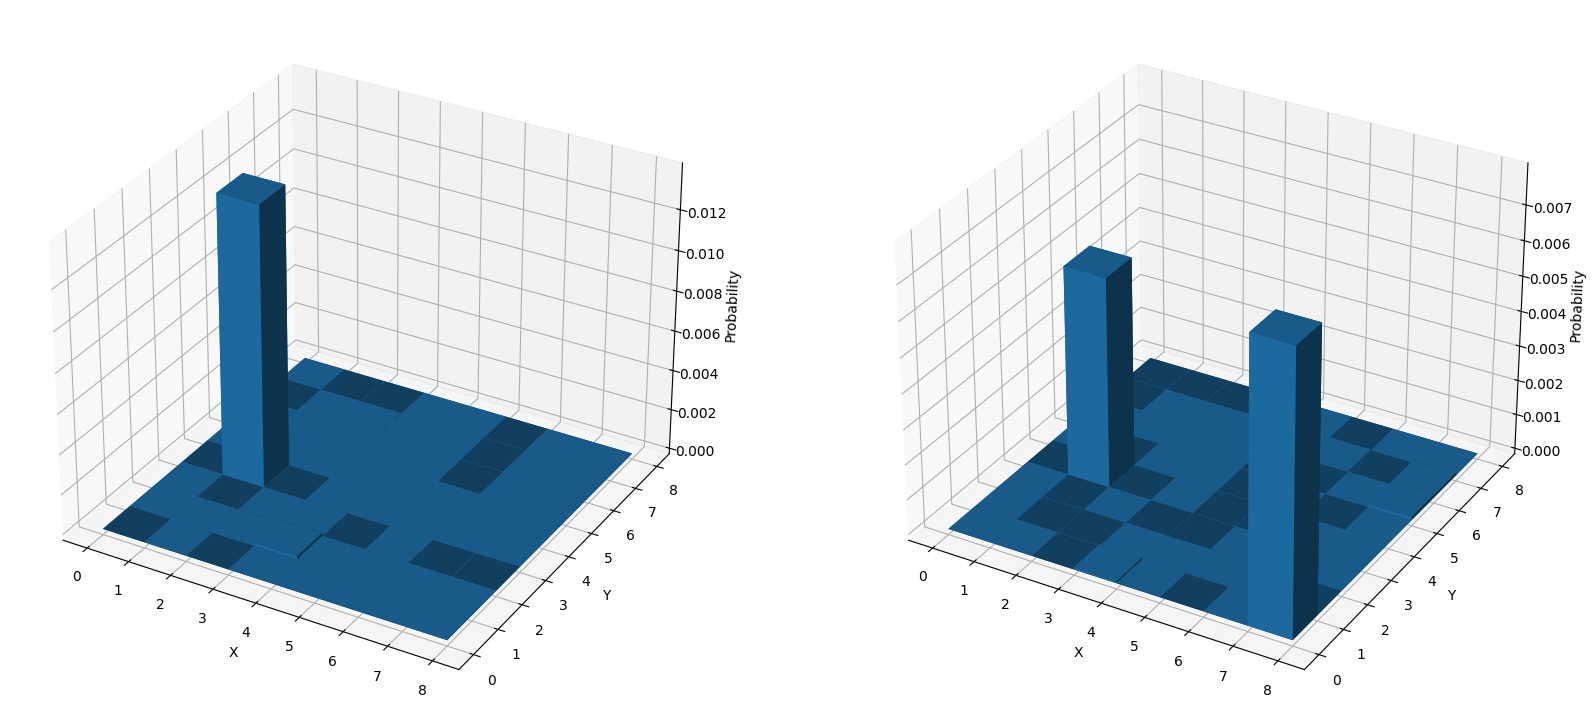

In [7]:
# do the same but mask illegal moves
legal_moves_mask = legal_moves(env)
action = action*legal_moves_mask

# transform actions to moves
moves = [int_action_to_move(a) for a in action.argsort()[::-1]]

from_moves_cords = [(m[0], m[1], prob) for m, prob in zip(moves, action)] 
to_moves_cords = [(m[2], m[3], prob) for m, prob in zip(moves, action)]

# accumulate probabilities
from_moves_probs = np.zeros((8, 8))
to_moves_probs = np.zeros((8, 8))

for from_x, from_y, prob in from_moves_cords:
    from_moves_probs[from_x, from_y] += prob 

for to_x, to_y, prob in to_moves_cords:
    to_moves_probs[to_x, to_y] += prob

# plot two 3d bar plots with probabilities of moving from and to
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# plot from
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X).ravel(), 1, 1, from_moves_probs.ravel())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability')

# plot to
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

ax2.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X).ravel(), 1, 1, to_moves_probs.ravel())
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Probability')


In [53]:
from tqdm.notebook import tqdm
N_GAME = 100

rewards = []
games_backtrace = []

#ai_agent = ChessAgent("v4-4")
ai_agent = ChessAgent("v4-3")
#ai_agent = ChessAgent("v4-2")
#ai_agent = ChessAgent("v6")

t = tqdm(range(N_GAME))
for i in t:
    state = env.reset()
    reward_sum = 0 
    backtrace = []   
    for it in range(10):
        action, _ = ai_agent.get_raw(state)
        #action = action*legal_moves(env)
        action = np.argmax(action)
 
        state1, reward1, done1 = env.step(int(action))

        # make random move
        state2, reward2, done2 = env.step(int(np.argmax((np.random.randn(4096)*legal_moves(env)))))

        reward = reward1 - max(reward2, 0)
        state = state2
        done = done1 or done2

        backtrace.append((state, action, reward, done, env.render()))

        if done:
            break
        reward_sum += reward

    avg = np.mean(rewards)
    t.set_description(f"Average reward: {avg:.2f}")
    
    rewards.append(reward_sum)
    games_backtrace.append(backtrace)

print(f"Average reward: {np.mean(rewards)}")
print(f"Max reward: {np.max(rewards)}")
print(f"Min reward: {np.min(rewards)}")
print(f"Std reward: {np.std(rewards)}")


  0%|          | 0/100 [00:00<?, ?it/s]

Average reward: 2.7
Max reward: 14
Min reward: -15
Std reward: 5.593746508378798


Text(0.5, 1.0, 'Reward per game')

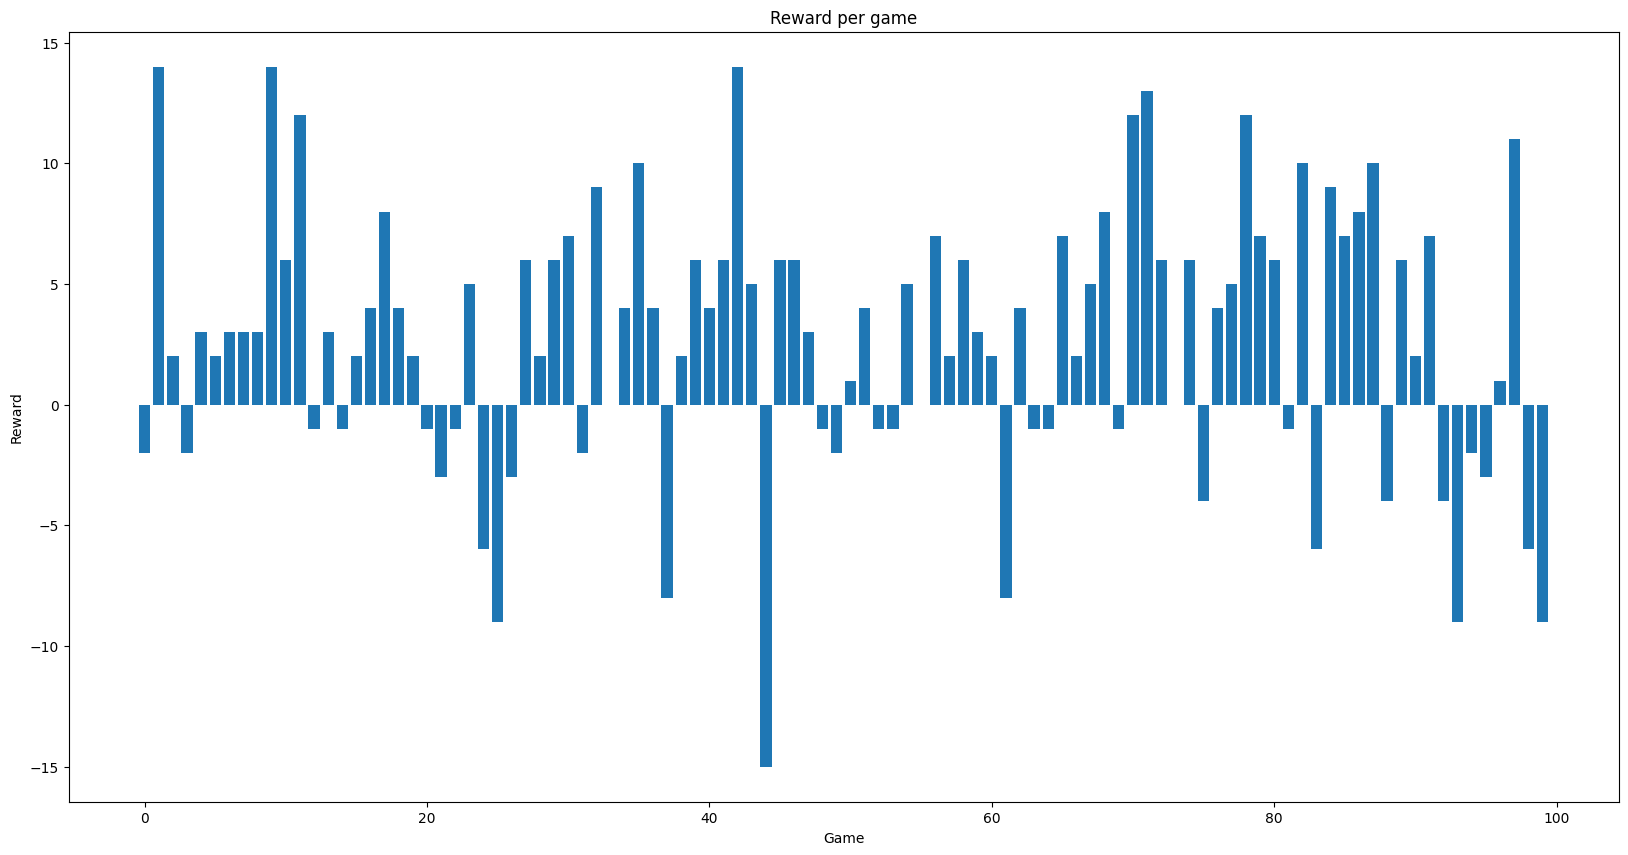

In [54]:
# plot reward bar plot
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(rewards)), rewards)
plt.xlabel("Game")
plt.ylabel("Reward")
plt.title("Reward per game")

Text(0.5, 1.0, 'Histogram of reward: $\\mu=2.70$, $\\sigma=5.59$')

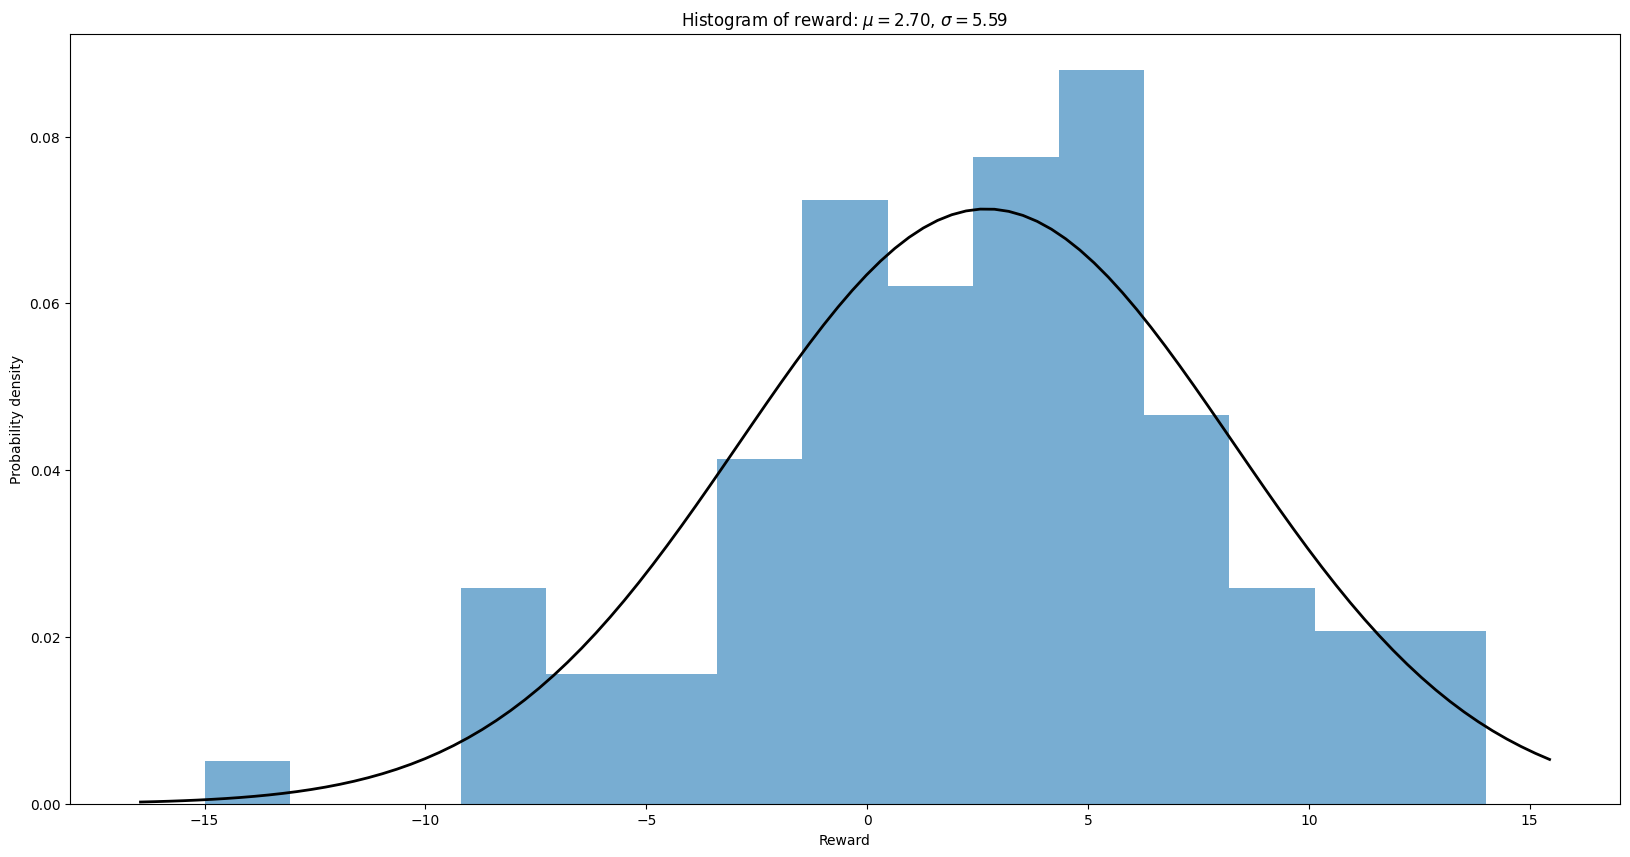

In [55]:
# plot histogram
from scipy.stats import norm

mu, std = norm.fit(rewards) 

ax = plt.figure(figsize=(20, 10)).add_subplot(111)
ax.hist(rewards, bins=15, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
ax.set_xlabel('Reward')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of reward: $\\mu={mu:.2f}$, $\\sigma={std:.2f}$')

Game 1 with reward 14, length: 10
Action: 193, reward: 0, done: False


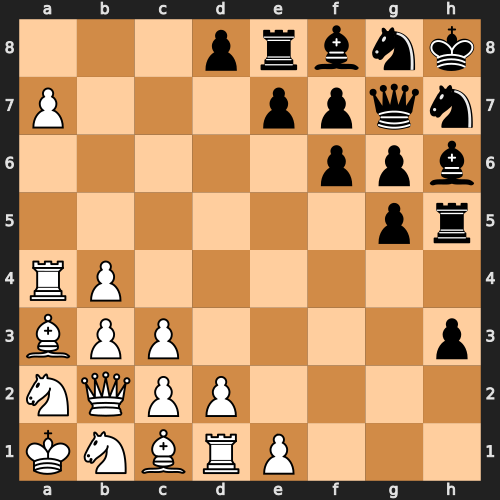

Action: 2551, reward: 0, done: False


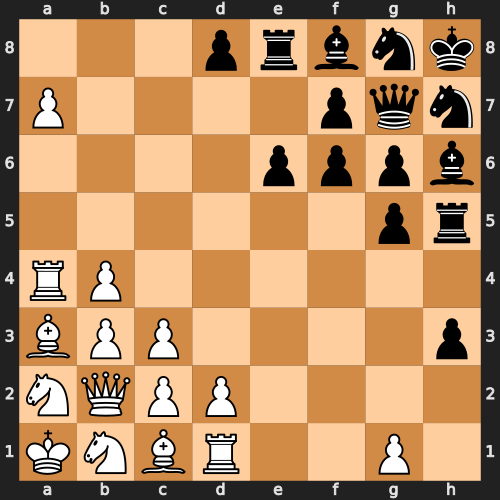

Action: 3583, reward: 0, done: False


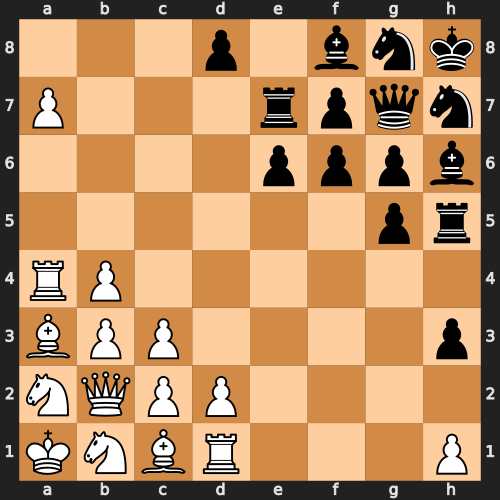

Action: 1966, reward: 0, done: False


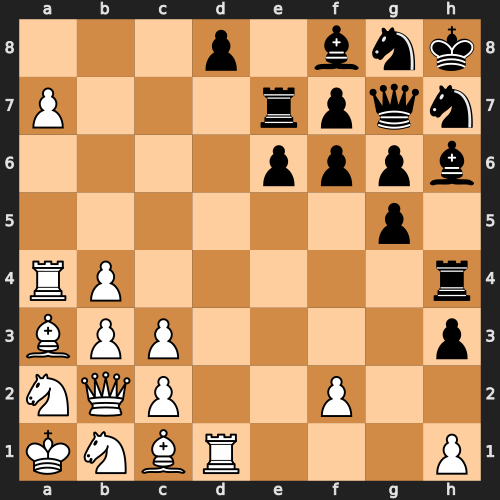

Action: 2008, reward: 5, done: False


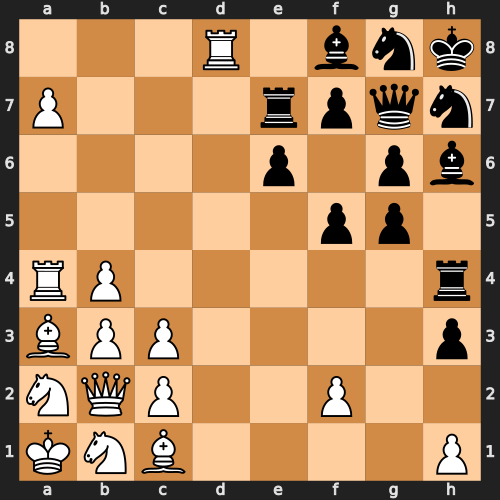

Action: 1523, reward: 5, done: False


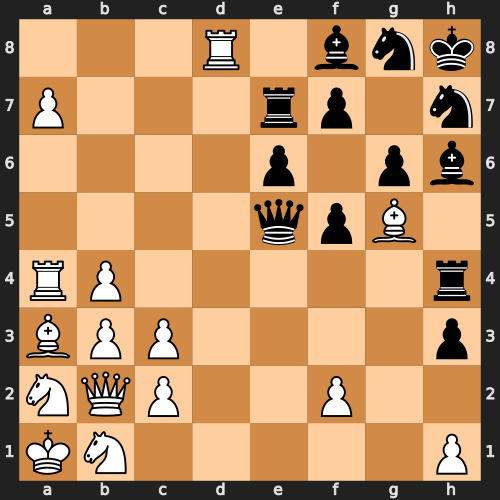

Action: 1446, reward: 0, done: False


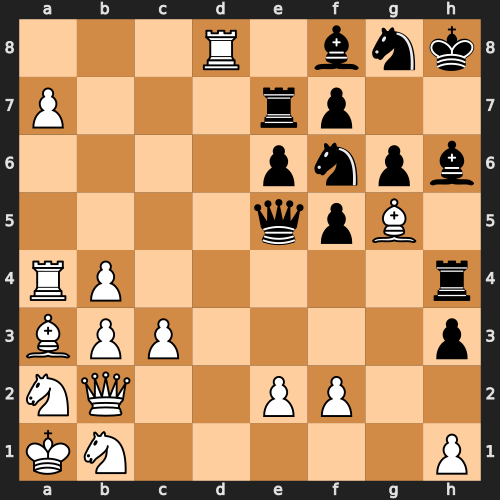

Action: 990, reward: 0, done: False


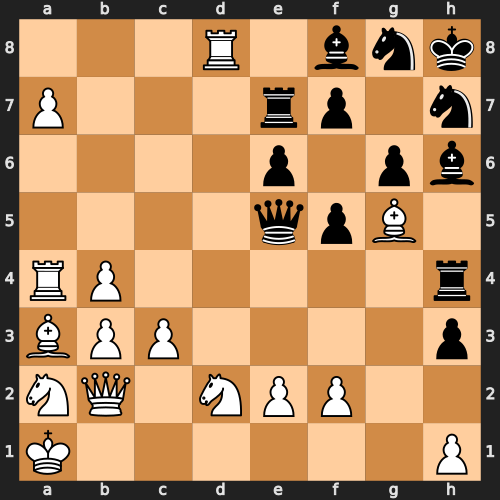

Action: 407, reward: 0, done: False


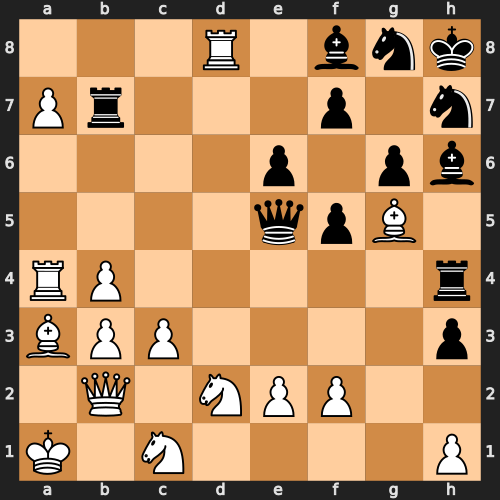

Action: 407, reward: 4, done: False


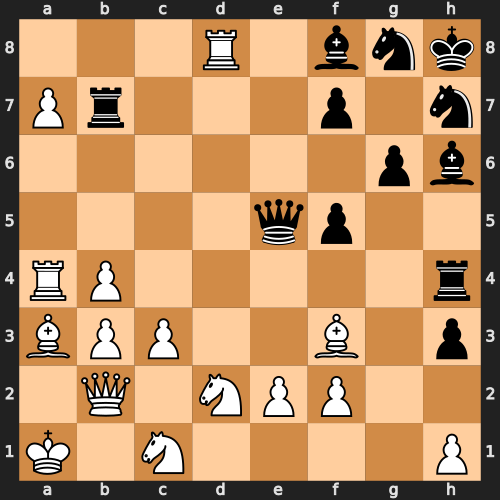

In [58]:
from IPython.display import display

# take 10th % of games with highest reward
selected_game = np.argsort(rewards)[::-1][0]
game = games_backtrace[selected_game]
print(f"Game {selected_game} with reward {rewards[selected_game]}, length: {len(game)}")

for state, action, reward, done, svg in game:
    print(f"Action: {action}, reward: {reward}, done: {done}")
    display(svg)